In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pyproj import Proj, Transformer
import numpy as np
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import make_axes_locatable
import netCDF4 as nc
import os
import glob
from shapely.geometry import Point, Polygon
from shapely.vectorized import contains  # Vectorized containment test for efficiency
import matplotlib.patches as patches
import matplotlib.path as mpath



def read_nc_file(nc_file):
    """
    Reads a NetCDF file and extracts its global attributes, dimensions, and variables.
    """
    data = {}
    with nc.Dataset(nc_file, 'r') as ds:
        data['global_attributes'] = {attr: ds.getncattr(attr) for attr in ds.ncattrs()}
        data['dimensions'] = {dim: len(ds.dimensions[dim]) for dim in ds.dimensions}
        data['variables'] = {}
        for var in ds.variables:
            variable_data = ds.variables[var][:]
            variable_attrs = ds.variables[var].__dict__
            data['variables'][var] = {
                'data': variable_data,
                'attributes': variable_attrs
            }
    return data

def print_nc_data(data):
    """
    Prints the contents of a NetCDF data dictionary.
    """
    print("Global Attributes:")
    for attr, value in data['global_attributes'].items():
        print(f"  {attr}: {value}")
    print("\nDimensions:")
    for dim, size in data['dimensions'].items():
        print(f"  {dim}: size = {size}")
    print("\nVariables:")
    for var, info in data['variables'].items():
        print(f"  {var}:")
        print(f"    Dimensions: {info['data'].shape}")
        for attr, value in info['attributes'].items():
            print(f"    {attr}: {value}")

def read_nc_files_in_directory(directory):
    data_list = []
    nc_files = glob.glob(os.path.join(directory, '*.nc'))
    for nc_file in nc_files:
        data = read_nc_file(nc_file)
        data_list.append(data)
    return data_list

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import matplotlib.path as mpath
from pyproj import Proj, Transformer
import numpy as np
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import make_axes_locatable
import netCDF4 as nc
import os
import glob
from shapely.geometry import Point, Polygon

def calculate_averages(nc_file_path, polygon, variables):
    """
    Calculate the average of specified variables within the given polygon.
    """
    try:
        with nc.Dataset(nc_file_path, 'r') as ds:
            # Extract latitude and longitude arrays from the NetCDF dataset
            latitude = ds.variables['latitude'][:]
            longitude = ds.variables['longitude'][:]

            # Create a meshgrid of longitude and latitude coordinates
            lon_grid, lat_grid = np.meshgrid(longitude, latitude)

            # Initialize a dictionary to store the averages of each variable
            averages = {}

            for var in variables:
                try:
                    # Extract data for the current variable
                    variable_data = ds.variables[var][:]
                except KeyError:
                    # Handle the case where the variable is not found in the dataset
                    print(f"Variable '{var}' not found in {nc_file_path}. Setting to None.")
                    averages[var] = None
                    continue

                # List to store values of the variable within the polygon
                values_in_polygon = []

                # Iterate over all grid points and corresponding variable values
                for lat, lon, value in zip(lat_grid.ravel(), lon_grid.ravel(), variable_data.ravel()):
                    # Create a point object for the current coordinate
                    point = Point(lon, lat)
                    # Check if the point lies within the specified polygon
                    if polygon.contains(point):
                        values_in_polygon.append(value)

                if values_in_polygon:
                    # Calculate the mean of the values inside the polygon, ignoring NaNs
                    averages[var] = np.nanmean(values_in_polygon)
                else:
                    # If no values are found within the polygon, set average to None
                    averages[var] = None
    except Exception as e:
        # Handle any exceptions that occur during processing
        print(f"Error processing {nc_file_path}: {e}")
        averages = {var: None for var in variables}
    return averages

def plot_utm_region(data, variable_name, polygon, time_index=0, limits=None,
                    colorbar=True, color_scale='continuous', threshold=None, step=1,
                    utm_zone=32, avg_polygon=None, list_of_polygons=None, nc_file_path=None):
    """
    Plots a UTM region with data from a NetCDF dictionary. If an additional polygon
    (avg_polygon) is provided, it is added to the plot and:
      - The average value of the plotted variable within that polygon is computed
        (via a matplotlib Path method) and added to the title.
      - The averages for the variables ['sst', 't2m', 'u10', 'v10', 'crr'] are calculated
        using the provided function and printed out.
    
    Args:
        data (dict): Dictionary with keys 'variables' (including 'longitude', 'latitude', etc.).
        variable_name (str): Name of the variable to plot.
        polygon (list): List of (lon, lat) tuples defining the main region of interest.
        time_index (int): Time index to use (if applicable).
        limits (tuple, optional): Color scale limits for continuous data.
        colorbar (bool): Whether to add a colorbar.
        color_scale (str): 'continuous' or 'binary'.
        threshold (float, optional): Threshold for binary scale.
        step (int, optional): Step for quiver plotting (for wind).
        utm_zone (int): UTM zone to use.
        avg_polygon (list, optional): A list of (lon, lat) tuples defining an additional polygon.
                                      The average of the variable within this polygon will be computed
                                      and added to the title.
        nc_file_path (str, optional): Path to the NetCDF file. If provided along with avg_polygon,
                                      averages for the listed variables will be computed and printed.
    """
    # Define projections using the provided utm_zone
    proj_utm = Proj(proj='utm', zone=utm_zone, ellps='WGS84', north=True)
    proj_wgs84 = Proj(proj='latlong', datum='WGS84')
    
    # Create transformers to convert between coordinate systems
    transformer_to_utm = Transformer.from_proj(proj_wgs84, proj_utm)
    transformer_to_wgs84 = Transformer.from_proj(proj_utm, proj_wgs84)
    
    # Transform the main polygon coordinates to UTM
    utm_coords = [transformer_to_utm.transform(lon, lat) for lon, lat in polygon]
    print("UTM polygon coordinates:", utm_coords)
    
    # Determine the bounding box of the main polygon
    min_x = min(utm_coords, key=lambda x: x[0])[0]
    max_x = max(utm_coords, key=lambda x: x[0])[0]
    min_y = min(utm_coords, key=lambda x: x[1])[1]
    max_y = max(utm_coords, key=lambda x: x[1])[1]
    
    if not all(np.isfinite(val) for val in [min_x, max_x, min_y, max_y]):
        raise ValueError("Computed map extents include non-finite values.")
    
    # Extract grid data for longitude and latitude
    longitude = data['variables']['longitude']['data']
    latitude = data['variables']['latitude']['data']
    
    # Process variable data based on the type of variable
    if variable_name == 'wind':
        u10 = data['variables']['u10']['data']
        v10 = data['variables']['v10']['data']
        variable_units = data['variables']['u10']['attributes']['units']
        variable_long_name = "10 metre wind"
        wind_speed = np.sqrt(u10[time_index, :, :]**2 + v10[time_index, :, :]**2)
        u10_norm = u10[time_index, :, :] / wind_speed
        v10_norm = v10[time_index, :, :] / wind_speed
        variable_data = wind_speed
        time = data['variables']['time']['data']
        hour = int(time[time_index] % 24)
    elif variable_name == 'crr':
        variable_data = data['variables'][variable_name]['data'] * 3600  # convert units
        variable_units = 'mm/h'
        variable_long_name = 'Convective Rain Rate'
        time = data['variables']['time']['data']
        hour = int(time[time_index] % 24)
    elif variable_name in ['t2m', 'sst']:
        variable_data = data['variables'][variable_name]['data'] - 273.15  # convert K to °C
        variable_data = variable_data[:, :]
        variable_units = '°C'
        variable_long_name = data['variables'][variable_name]['attributes']['long_name']
        time = data['variables']['time']['data']
        hour = int(time[0] % 24)
    else:
        variable_data = data['variables'][variable_name]['data']
        variable_data = variable_data[:, :]
        variable_units = data['variables'][variable_name]['attributes']['units']
        variable_long_name = data['variables'][variable_name]['attributes']['long_name']
        time = data['variables']['time']['data']
        hour = int(time[0] % 24)
    
    # Create a meshgrid for the grid coordinates and transform them to UTM
    lon_grid, lat_grid = np.meshgrid(longitude, latitude)
    x_utm, y_utm = transformer_to_utm.transform(lon_grid, lat_grid)
    
    # Create the plot using Cartopy with the specified UTM zone
    fig, ax = plt.subplots(figsize=(20, 15), subplot_kw={'projection': ccrs.UTM(zone=utm_zone)})
    ax.set_extent([min_x, max_x, min_y, max_y], crs=ccrs.UTM(zone=utm_zone))
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.top_labels = False
    gl.right_labels = False
    
    # Plot the variable data with a pcolormesh
    if color_scale == 'continuous':
        var_plot = ax.pcolormesh(x_utm, y_utm, variable_data[:, :], cmap='coolwarm', transform=ccrs.UTM(zone=utm_zone))
        if limits is not None:
            var_plot.set_clim(limits)
    elif color_scale == 'binary':
        binary_data = variable_data[:, :] > threshold
        cmap = mcolors.ListedColormap(['blue', 'red'])
        bounds = [0, 0.5, 1]
        norm = mcolors.BoundaryNorm(bounds, cmap.N)
        var_plot = ax.pcolormesh(x_utm, y_utm, binary_data, cmap=cmap, norm=norm, transform=ccrs.UTM(zone=utm_zone))
    
    if variable_name == 'wind':
        ax.quiver(x_utm[::step, ::step], y_utm[::step, ::step],
                  u10_norm[::step, ::step], v10_norm[::step, ::step], scale=20)
    
    if colorbar:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1, axes_class=plt.Axes)
        cbar = fig.colorbar(var_plot, cax=cax, orientation='vertical')
        if color_scale == 'binary':
            cbar.set_ticks([0, 1])
            cbar.set_ticklabels([f'Below {threshold}', f'Above {threshold}'])
            cbar.set_label(f'{variable_name} Threshold ({variable_units})', fontsize=12)
        else:
            cbar.set_label(f'{variable_long_name} ({variable_units})', fontsize=12)
    
    # Define a helper function to add a polygon using the given transformer
    def add_polygon(ax, polygon_coords, edgecolor='red', facecolor='none', linewidth=1,
                    transform=ccrs.UTM(zone=utm_zone)):
        # Transform the polygon coordinates to UTM using the existing transformer
        utm_coords_poly = [transformer_to_utm.transform(lon, lat) for lon, lat in polygon_coords]
        poly = patches.Polygon(utm_coords_poly, edgecolor=edgecolor, facecolor=facecolor,
                               linewidth=linewidth, transform=transform)
        ax.add_patch(poly)
    
    polygon_mean = None
    # If an additional polygon is provided, add it and compute the average value inside it.
    if avg_polygon is not None:
        # Add the polygon to the plot with a red dashed outline.
        add_polygon(ax, avg_polygon, edgecolor='red', facecolor='none', linewidth=2)
        
        # Calculate the average value within the polygon using matplotlib.path.Path
        utm_coords_aoi = [transformer_to_utm.transform(lon, lat) for lon, lat in avg_polygon]
        polygon_path = mpath.Path(utm_coords_aoi)
        points = np.vstack((x_utm.ravel(), y_utm.ravel())).T
        mask = polygon_path.contains_points(points).reshape(x_utm.shape)
        polygon_data = variable_data[mask]
        if polygon_data.size == 0:
            polygon_mean = None
            print("No ERA5 Grid Cell center found within the polygon!")
        elif variable_name == 'crr':
            polygon_mean = round(np.nanmean(polygon_data), 7)
        else:
            polygon_mean = round(np.nanmean(polygon_data), 2)
    
    # plot list of polygons if provided
    if list_of_polygons is not None:
        for poly in list_of_polygons:
            add_polygon(ax, poly, edgecolor='black', facecolor='none', linewidth=2)
    

    # Set the title to include the computed average (if available)
    title = f'{variable_long_name}'
    if polygon_mean is not None and np.isfinite(polygon_mean):
        title += f" (Avg: {polygon_mean} {variable_units})"
    ax.set_title(title, fontsize=14)
    
    plt.tight_layout()
    # plt.savefig('/home/mtontsch/Nextcloud/results/era5_averages.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # If a NetCDF file path is provided along with an avg_polygon,
    # call the calculate_averages function for the listed variables and print the results.
    if avg_polygon is not None and nc_file_path is not None:
        # Create a shapely Polygon from the avg_polygon coordinates
        aoi_polygon = Polygon(avg_polygon)
        variables_list = ['sst', 't2m', 'u10', 'v10', 'crr']
        avg_results = calculate_averages(nc_file_path, aoi_polygon, variables_list)
        print("Averages within the polygon (from calculate_averages):")
        for var, val in avg_results.items():
            print(f"  {var}: {val}")

In [3]:
# directory = "/mnt/raid01/SAR/Sentinel-1/Arctic/WesternSvalbard/era5_temp/"
# directory = "/mnt/raid01/SAR/Sentinel-1/Arctic/ArcticDeepSeepsData/DeepSeepNet_application/ScottTrough/era5/"
# data_list = read_nc_files_in_directory(directory)
# print_nc_data(data_list[0])


# file_path =  '/mnt/raid01/SAR/Sentinel-1/Arctic/WesternSvalbard/era5_temp/S1A_EW_GRDM_1SDH_20170731T071219_20170731T071323_017712_01DA9D_0FD5_era5.nc'
file_path = '/mnt/raid01/SAR/Sentinel-1/Arctic/ScottTrough/asdf/overview/era5_all/era5_20160118_hour12_extracted.nc'
data = read_nc_file(file_path)
print_nc_data(data)

# print the time dimension
# time = data_list[0]['variables']['time']['data']
# print(time)

Global Attributes:
  Conventions: CF-1.6
  history: 2020-11-26 23:09:43 GMT by grib_to_netcdf-2.16.0: /opt/ecmwf/eccodes/bin/grib_to_netcdf -o /cache/data4/adaptor.mars.internal-1606432158.6201198-21506-21-4e9b6fdd-a38a-408a-833c-191404f37de8.nc /cache/tmp/4e9b6fdd-a38a-408a-833c-191404f37de8-adaptor.mars.internal-1606432158.6206748-21506-9-tmp.grib

Dimensions:
  longitude: size = 40
  latitude: size = 13
  time: size = 5

Variables:
  longitude:
    Dimensions: (40,)
    units: degrees_east
    long_name: longitude
  latitude:
    Dimensions: (13,)
    units: degrees_north
    long_name: latitude
  time:
    Dimensions: (5,)
    units: hours since 1900-01-01 00:00:00.0
    long_name: time
    calendar: gregorian
  t2m:
    Dimensions: (13, 40)
    _FillValue: -32767.0
    scale_factor: 0.0009642035165161303
    add_offset: 254.05079505888628
    missing_value: -32767
    units: K
    long_name: 2 metre temperature
  sst:
    Dimensions: (13, 40)
    _FillValue: -32767.0
    scale_fac

UTM polygon coordinates: [(675714.8465139506, 8793251.823087996), (476210.57820395136, 8875899.3395269), (395883.04011565144, 8683434.160294607), (595901.971946376, 8598986.656883711), (675714.8465139506, 8793251.823087996)]


/home/mtontsch/micromamba/envs/SAR_preprocessing/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1768: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)


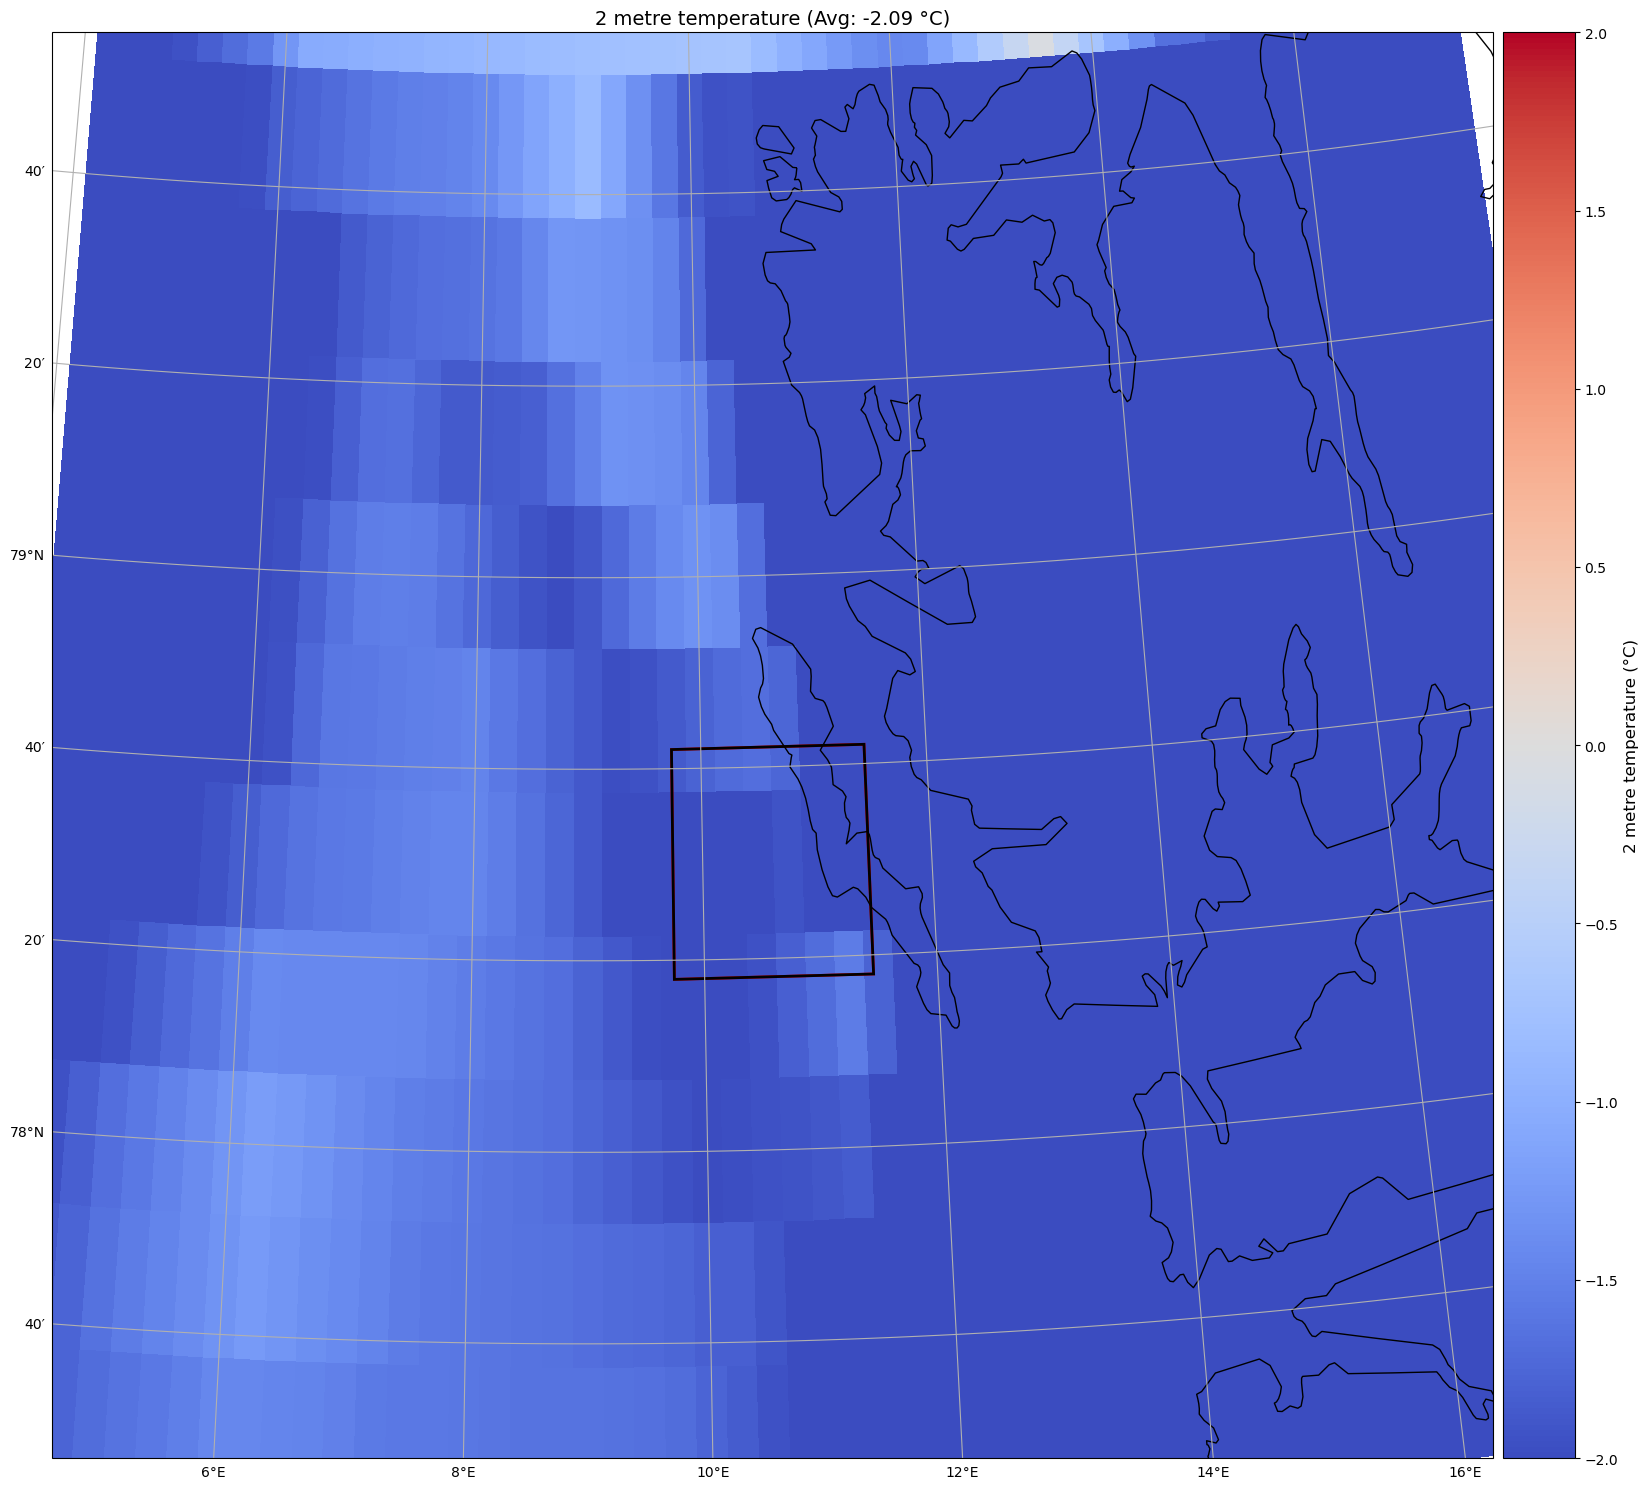

Averages within the polygon (from calculate_averages):
  sst: 274.0709689320537
  t2m: 271.05627664714365
  u10: 0.5407772481951225
  v10: 0.22896982600037186
  crr: 0.0


In [6]:
# file_path = '/mnt/raid01/SAR/Sentinel-1/Arctic/ScottTrough/asdf/overview/era5/S1A_EW_GRDM_1SDH_20150822T112938_20150822T113038_007375_00A239_EB48_era5.nc'
# file_path = '/mnt/raid01/SAR/Sentinel-1/Arctic/ArcticDeepSeepsData/DeepSeepNet_application/ScottTrough/era5/S1A_EW_GRDM_1SDH_20240822T113029_20240822T113129_055325_06BF04_6B26_era5.nc'
file_path = '/mnt/raid01/SAR/Sentinel-1/Arctic/ArcticDeepSeepsData/application_dataset/WesternSvalbard/era5/S1A_EW_GRDM_1SDH_20240101T072106_20240101T072211_051910_06458D_A190_era5.nc'
netCDF4_file = read_nc_file(file_path)
# print_nc_data(netCDF4_file)

# # print min max of t2m
# t2m = netCDF4_file['variables']['']['data']
# print(np.nanmin(t2m), np.nanmax(t2m))

polygon_era5_scott = [(-72.8681, 70.2276), (-62.7658, 70.2276), (-62.7658, 73.2658), (-72.8681, 73.2658), (-72.8681, 70.2276)]
# POLYGON ((17.348031736876255 79.09572897318715, 7.779175985684506 79.94681686779909, 4.439261217571242 78.18822495833791, 12.953061411867276 77.43893857423194, 17.348031736876255 79.09572897318715))
polygon_era5_svalbard = [(17.348031736876255, 79.09572897318715), (7.779175985684506, 79.94681686779909), (4.439261217571242, 78.18822495833791), (12.953061411867276, 77.43893857423194), (17.348031736876255, 79.09572897318715)]
# polygon_era5_svalbard = [(18.025, 79.120), (7.455, 80.062), (3.886, 78.143), (13.175, 77.326), (18.025, 79.120)]


# SCOTT center 512 POLYGON ((-70.43676414818104 71.29736227069641, -69.86457831606064 71.30085507069988, -69.87284138831794 71.4844543044091, -70.4504920724535 71.48092439468037, -70.43676414818104 71.29736227069641))
# avg_polygon = [(-70.43676414818104, 71.29736227069641), (-69.86457831606064, 71.30085507069988), (-69.87284138831794, 71.4844543044091), (-70.4504920724535, 71.48092439468037), (-70.43676414818104, 71.29736227069641)]
# SCOTT AOI: POLYGON((-70.75 71.19,-69.55 71.19,-69.55 71.59,-70.75 71.59,-70.75 71.19))
# avg_polygon = [(-70.75, 71.19), (-69.55, 71.19), (-69.55, 71.59), (-70.75, 71.59), (-70.75, 71.19)]
# # SCOTT BIG: POLYGON((-71.395 71.032, -68.645 71.032, -68.645 71.912, -71.395 71.912, -71.395 71.032))
# avg_polygon = [(-71.395, 71.032), (-68.645, 71.032), (-68.645, 71.912), (-71.395, 71.912), (-71.395, 71.032)]


# additional argument list_of_polygons
list_of_polygons_scott = [
    [(-70.43676414818104, 71.29736227069641), (-69.86457831606064, 71.30085507069988), (-69.87284138831794, 71.4844543044091), (-70.4504920724535, 71.48092439468037), (-70.43676414818104, 71.29736227069641)],
    [(-71.395, 71.032), (-68.645, 71.032), (-68.645, 71.912), (-71.395, 71.912), (-71.395, 71.032)],
    [(-70.75, 71.19), (-69.55, 71.19), (-69.55, 71.59), (-70.75, 71.59), (-70.75, 71.19)]
]
avg_polygon = list_of_polygons_scott[2]


list_of_polygons_svalbard = [
    [(9.74, 78.3), (11.45, 78.3), (11.45, 78.7), (9.74, 78.7), (9.74, 78.3)]
]
avg_polygon = list_of_polygons_svalbard[0]

# Call the plotting function with the additional parameters.
plot_utm_region(data=netCDF4_file, variable_name='t2m', polygon=polygon_era5_svalbard,
                time_index=1, limits=[-2, 2], colorbar=True, color_scale='continuous',
                step=2, utm_zone=32, avg_polygon=avg_polygon, list_of_polygons=list_of_polygons_svalbard, nc_file_path=file_path)



# Other

In [25]:
# histogram that plots t2m values
def plot_histogram(data):
    data_val = data.flatten()

    # Plot histogram for t2m
    plt.figure(figsize=(6, 6))
    plt.hist(data_val, bins=50, color='blue', alpha=0.7)
    plt.title('Histogram of variable')
    plt.xlabel('Data domain')
    plt.ylabel('Frequency')

    plt.show()

plot_histogram(data_list[0]['variables']['u10']['data'])


NameError: name 'data_list' is not defined